In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\ADITH SREE RAM\Downloads\lungs.csv', sep = ',')

In [3]:
df.shape

(309, 16)

In [4]:
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,OUTCOME
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


In [5]:
df.columns = [col.lower() for col in df.columns]
df.head()

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic disease,fatigue,allergy,wheezing,alcohol consuming,coughing,shortness of breath,swallowing difficulty,chest pain,outcome
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


<Axes: >

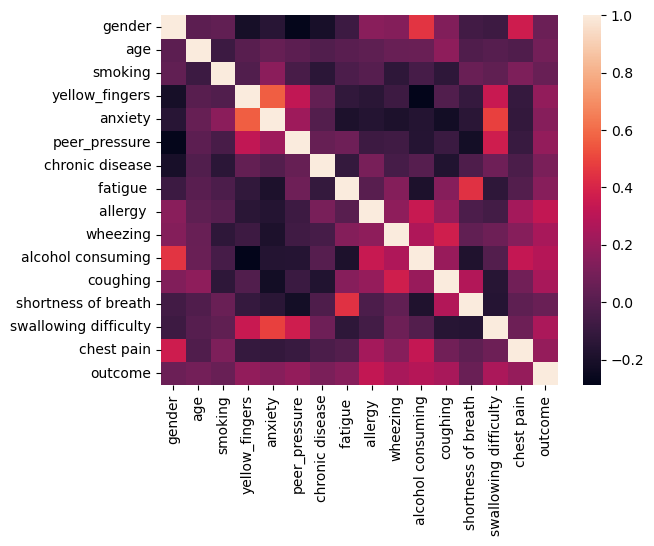

In [6]:
corr = df.corr()

sns.heatmap(corr,
         xticklabels=corr.columns,
         yticklabels=corr.columns)

In [7]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 309
Variables: 16
cat_cols: 15
num_cols: 1
cat_but_car: 0
num_but_cat: 15


In [8]:
def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + interquantile_range
    low_limit = quartile1 - 1.3 * interquantile_range
    return low_limit, up_limit
        

In [9]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [10]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
    for col in df.columns:
        print(col, grab_outliers(df,col))

In [11]:
def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
        print(replace_with_thresholds(df, col))

None


In [12]:
df.head()

,gender,age,smoking,yellow_fingers,anxiety,peer_pressure,chronic disease,fatigue,allergy,wheezing,alcohol consuming,coughing,shortness of breath,swallowing difficulty,chest pain,outcome
0,1,69.0,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74.0,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59.0,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63.0,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63.0,0,1,0,0,0,0,0,1,0,1,1,0,0,0


In [13]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

knn_model = KNeighborsClassifier().fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9516129032258065

In [14]:
knn_params = {"n_neighbors": np.arange(1,50)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [15]:
print("Best params " + str(knn_cv.best_params_))

Best params {'n_neighbors': 6}


In [16]:
knn = KNeighborsClassifier(n_neighbors=7)
knn_tuned = knn.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
k = accuracy_score(y_test, y_pred)
k

0.967741935483871

In [17]:
### Random Forest

In [18]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf=accuracy_score(y_test, y_pred)
rf

0.967741935483871

In [19]:
### Gradient boosting

In [20]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)
gb = accuracy_score(y_test, y_pred)
gb

0.9516129032258065

In [21]:
### xgbm

In [22]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

xgbm_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgbm_model.predict(X_test)
xgb=accuracy_score(y_test, y_pred)
xgb

0.9838709677419355

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats import expon, uniform

dtc=DecisionTreeClassifier(criterion='entropy', random_state=42)
ada = AdaBoostClassifier(dtc,random_state=42)
predictor = ada.fit(X_train, y_train)
y_pred = predictor.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred)

print(accuracy_ada)

0.9838709677419355


In [24]:
LRclassifier = LogisticRegression(max_iter=1000, random_state=1, solver='liblinear', penalty='l1')
LRclassifier.fit(X_train, y_train)

y_pred_LR = LRclassifier.predict(X_test)
LRAcc = accuracy_score(y_pred_LR, y_test)
print(LRAcc)

0.9516129032258065


In [25]:
DTCclassifier = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, criterion='entropy', min_samples_split=5,
                                       splitter='random', random_state=1)

DTCclassifier.fit(X_train, y_train)
y_pred_DTC = DTCclassifier.predict(X_test)
DTCAcc = accuracy_score(y_pred_DTC, y_test)
print(DTCAcc)

0.9354838709677419


In [26]:
SVMclassifier = SVC(kernel='linear', max_iter=1000, C=10, probability=True)
SVMclassifier.fit(X_train, y_train)

y_pred_SVM = SVMclassifier.predict(X_test)
SVMAcc = accuracy_score(y_pred_SVM, y_test)
print(SVMAcc)

0.8225806451612904


In [27]:
GNBclassifier = GaussianNB(var_smoothing=0.1)
GNBclassifier.fit(X_train, y_train)

y_pred_GNB = GNBclassifier.predict(X_test)
GNBAcc = accuracy_score(y_pred_GNB, y_test)
print(GNBAcc)

0.967741935483871


In [28]:
models = pd.DataFrame({
    'Model' : [ 'KNN', 'Decision Tree', 'Random Forest','Ada Boost',
             'Gradient Boosting', 'XgBoost', 'Logistic Regression', 'Naive Bayes', 'SVM'],
    'Accuracy' : [k, DTCAcc, rf, accuracy_ada, gb, xgb,LRAcc, GNBAcc, SVMAcc]
})


df1 = models.sort_values(by = 'Accuracy', ascending = False)

Text(0.5, 1.0, 'Model Vs Accuracy for Diabetes')

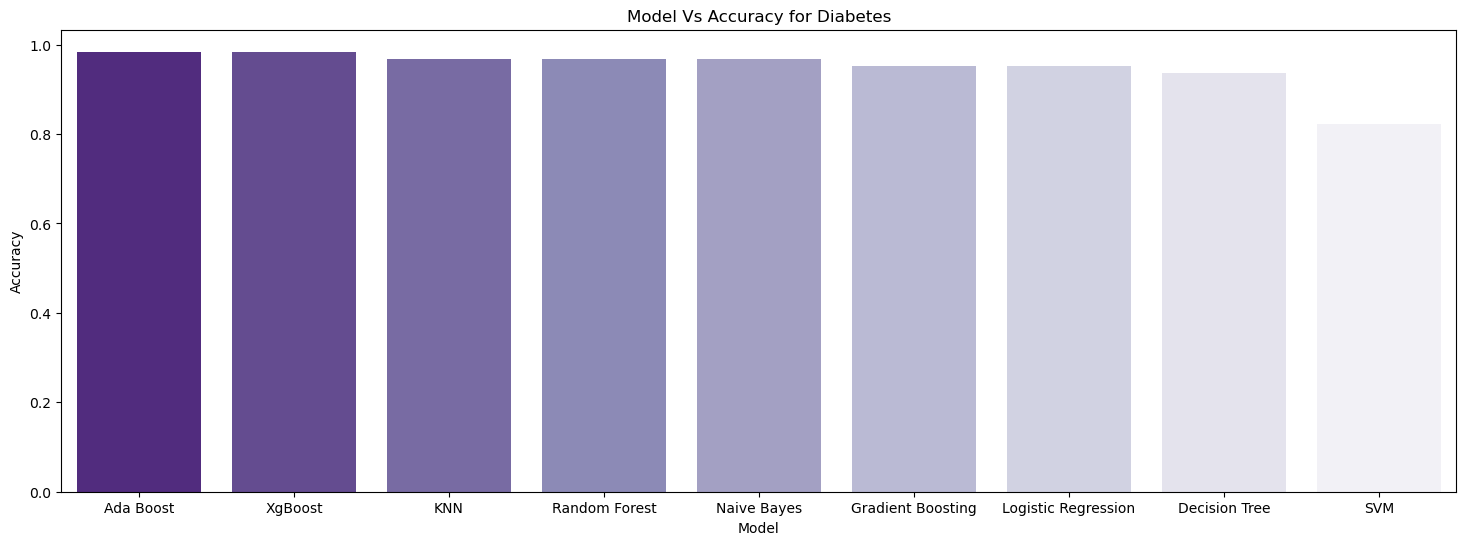

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,6))
sns.barplot(df1, x = 'Model', y = 'Accuracy', palette = 'Purples_r')
plt.title("Model Vs Accuracy for Diabetes")

In [30]:
import joblib

In [31]:
file = open("lung_cancer", "wb")
joblib.dump(ada,file)
file.close()